In [1]:
import numpy as np
import pandas as pd
# import pickle
import cPickle as pickle

import gzip

# from joblib import Parallel, delayed
# import multiprocessing
from methods.index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec

import bisect
from scipy import interpolate

from joblib import Parallel, delayed
import multiprocessing

from scipy import stats
from methods.xflib import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')
from scipy.integrate import nquad

from methods.GLD_file_tools import GLD_file_tools

from methods.precip_model import precip_model, build_database

# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

#### This version for multiple energy bands:

In [2]:
## Load precalculated stencils:
suffix = 'AE8MAX_flux_0' # ae8max,
#suffix = 'AE8MAX_flux_1' # bell model
# suffix = 'AE8MAX_flux_2' # propensity
# suffix = 'AE8MIN_flux_0' # ae8minx
nb = 64
with open('../outputs/precip_dbs/precalculated_stencils_%s_%db.pkl'%(suffix, nb),'rb') as file:
    precalc_stencils = pickle.load(file)

with open('../outputs/precip_dbs/nightside_%s_%db.pkl'%(suffix, nb),'rb') as file:
    db = pickle.load(file)

In [3]:
# Get Kp data
Ktimes, Kp_arr = load_Kp()
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp_arr = np.array(Kp_arr)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp_arr[0:-8],Kp_arr[1:-7],Kp_arr[2:-6], Kp_arr[3:-5],
                Kp_arr[4:-4],Kp_arr[5:-3],Kp_arr[6:-2], Kp_arr[7:-1], Kp_arr[8:]],axis=0)
Kpmtimes = Ktimes[8:]


unique_Kpm = np.unique(Kpmax)
# print unique_Kpm

In [4]:
# Get energy vector (just loading from a file instead of calculating it here)
with gzip.open('/shared/users/asousa/WIPP/WIPP_stencils/outputs/stencils/nightside/stencil_30f_0.2L/kp0/phi_inlat_15_AE8MAX_flux_0.pklz','rb') as file:
    data = pickle.load(file)

E = data['params']['E_tot_arr']

Q_NH Q_SH
0.000374189072096 -1.26793538577e-06
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band 45
band 46
band 47
band 48
band 49
band 50
band 51
band 52
band 53
band 54
band 55
band 56
band 57
band 58
band 59
band 60
band 61
band 62
band 63
Q_NH Q_SH
5.05189393391e-05 -2.92436166405e-07
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band

IndexError: index 9 is out of bounds for axis 1 with size 9

In [ ]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 0.5
sec_in_year = 60*60*24*365.25

data_path = '../../lightning_power_study/outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

unique_kp = [0.,0.3,0.7, 1.,1.3, 1.7, 2.,2.3, 2.7, 3., 3.3, 3.7, 4., 4.3, 4.7,5.,5.3,5.7,6.,6.3,6.7,7.,7.3,7.7,8.]
inlats = np.arange(15, 56, 1) 
stencil_lats = np.hstack([np.arange(-90, -20,0.5),(np.arange(19.5,90,0.5))])
stencil_lons = np.linspace(-14, 14, 57)

cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(stencil_lats) + dlat/2.0)*D2R))

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()

# Set up grid:
gridlons = np.arange(-180, 180, 0.5)
gridlats = stencil_lats #np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])
dlat=0.5
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))





cur_map_total = np.zeros([180, 360])
count=0
counts = dict()


n_bands = 64

dtvec = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in files]

starttime = datetime.datetime(2015,1,1,0,0,0)
stoptime =   datetime.datetime(2016,1,1,0,0,0)

times_todo = sorted([x for x in dtvec if x >= starttime and x < stoptime])
total_files = len(times_todo)



for f_ind, filetime in enumerate(times_todo):
    print "loading %d/%d"%(f_ind, total_files)
    filename = filetime.strftime('%m_%d_%Y_%H_%M') + '.pklz'
    print filename
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')

        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']

        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(np.abs(cur_map) > 0)
        
        
        outkey = int(np.round(10.*Kpm))        
        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        
        count += 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
#             print x, y
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(cur_map_lats[x])))
        
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
#             print key
#             key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
#             outkey = (cur_mlt, int(np.round(10.*Kpm)))
            outkey = cur_mlt
#             # this version to just do average day + night
#             outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key].swapaxes(0,1)*I

                # Add to respective map:
                lonleft  = int(y*2 - len(stencil_lons)/2 - 1)
                lonright = int(y*2 + len(stencil_lons)/2)
                
#                 print lonleft, lonright
#                 print gridlons[lonleft], gridlons[lonright]
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(gridlons), len(gridlats), n_bands])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:,:] += \
                            stencil[0:np.abs(lonleft),:,:]

                elif lonright > len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :,:]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :,:] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
#     pwr_maps[k] *= period_factor/counts[k[1]]
#     pwr_maps[k] /= counts[k]   # Average over each 3-hour frame
    pwr_maps[k] /= count   # Average over each 3-hour frame
    pwr_maps[k] /= file_duration  # Total precip -> counts/cm^2/sec
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100

In [ ]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 0.5
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))
cell_areas_lightning = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(np.arange(-90,90,0.5)) + 0.25)*D2R))



# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 9
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [0, 10]


band_index = 20

fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

print np.shape(gridlons)
print np.shape(gridlats)
print np.shape(pwr_maps[0][:])

print np.min(pwr_maps[0]), np.max(pwr_maps[0])
p0 = ax[0].pcolormesh(gridlons, gridlats, pwr_maps[0][:,:,band_index].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
p1 = ax[1].pcolormesh(gridlons, gridlats, pwr_maps[12][:,:,band_index].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
ax[0].set_ylim([-70,70])
ax[1].set_ylim([-70,70])

twinx0 = ax[0].twinx()
twinx0.set_ylim([-70,70])
# twinx0.set_xticks([])
ytix = np.array([-65,-45,-25, 25,45,65])
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
ytix_L_labels = ['%.1f'%z for z in ytix_L]
twinx0.set_yticks(ytix)
twinx0.set_yticklabels(ytix_L_labels)


# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Electron Average Number Flux \n[#/cm$^2$/ev/sec]') 


cmt = cur_map_total/(f_ind + 1)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas_lightning[np.newaxis,:]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

clims2 = [-8, -3]
# print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolorfast(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-70, 70])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 


ax[0].set_xticks([])
ax[0].set_ylabel('Night\nLatitude (magnetic)')
ax[1].set_ylabel('Day\nLatitude (magnetic)')
ax[1].set_xticks([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')

ax[0].set_title('Average electon flux at ionosphere')
gs.tight_layout(fig)

# fig.savefig('Energy_density_daynite.png',dpi=300)

In [ ]:
# Find total spectrum vs latitude:
# Plot spectral density vs L-shell over the US:
flux_vs_lat = dict()

lonlims = [-50, 10]  # ~ approximately over the US
lonlims = [-180, 180]  # ~ approximately over the US
clims = [-8, 4]
left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

latlims = [-70, 70]
grid_E = []
for (p1, p2) in db['band_pairs']:
    grid_E.append((E[np.round((p1 + p2)/2)]))
#     print "fuck"

grid_E = np.array(grid_E)

E_min = 1e3
E_max = 1e8



print np.shape(pwr_maps_linear[0])
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    flux_vs_lat[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    flux_vs_lat[k] = np.log10(flux_vs_lat[k])
    flux_vs_lat[k][np.isinf(flux_vs_lat[k])] = -100

    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
cax = plt.subplot(gs[0:2,1])

# # Find maximum value across all keys:
# mv = -100
# for k in flux_vs_lat.keys():
#     if np.max(flux_vs_lat[k]) > mv:
#         mv = np.max(flux_vs_lat[k])
mv = 0

for ind, k in enumerate(flux_vs_lat.keys()):
    # upsample for smoothness of plotting:
    print np.shape(flux_vs_lat[k])
    pinterp = interpolate.RegularGridInterpolator([gridlats, grid_E], flux_vs_lat[k] , bounds_error=False, fill_value=-100)
    px, py = np.meshgrid(gridlats, E)
    pts = zip(px.ravel(), py.ravel())
    
    D_interp = pinterp(pts).reshape(len(E), len(gridlats)).T
    print np.shape(D_interp)
    
    p = ax[ind].pcolormesh(E, gridlats, D_interp, vmin = clims[0], vmax=clims[1], cmap = plt.get_cmap('jet'))
    
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')

    ax[ind].set_ylim(latlims)
    twinx0 = ax[ind].twinx()
    twinx0.set_ylim(latlims)
    # twinx0.set_xticks([])
    ytix = np.array([-65,-45,-25, 25,45,65])
    ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
    ytix_L_labels = ['%.1f'%z for z in ytix_L]
    twinx0.set_yticks(ytix)
    twinx0.set_yticklabels(ytix_L_labels)


    print np.min(flux_vs_lat[k]), np.max(flux_vs_lat[k])
ax[0].set_xticks([])
ax[0].set_ylabel('Latitude\nNightside')
ax[-1].set_ylabel('Latitude\nDayside')
ax[-1].set_xlabel('Energy [ev]')

ax[0].set_xscale("log", nonposx='clip')
ax[1].set_xscale("log", nonposx='clip')


# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Flux spectral density [mErg/cm$^2$/sec/ev]') 
# cb.set_label('Normalized scattering propensity [max(#)/cm$^2$/sec/ev]') 
# cb.set_label('scattering propensity (relative to max)\n[mErg/cm$^2$/sec/ev/max]') 


# ax[0].set_title('Global Average Lightning Spectra vs Field Line')

fig.subplots_adjust(right=0.8)
ax[0].set_xlim([2e1, 1e8])
ax[1].set_xlim([2e1, 1e8])

ax[0].set_xticks([])
gs.tight_layout(fig)


# fig.savefig('scattering_propensity_energy_vs_latitude.png',dpi=150)

In [ ]:
d = os.listdir(data_path)
files  = [x for x in d if x.endswith('.pklz')]
years  = np.unique(np.array([int(x.split('_')[2]) for x in files]))
months = np.unique(np.array([int(x.split('_')[0]) for x in files]))
days   = np.unique(np.array([int(x.split('_')[1]) for x in files]))
hours  = np.unique(np.array([int(x.split('_')[3]) for x in files])) 
print years
print months
print days
print hours



In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(dtvec, np.ones_like(dtvec),'x')

## Try single-machine parallelization (shared memory):

In [118]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25

num_cores = multiprocessing.cpu_count()


data_path = '../../lightning_power_study/outputs/GLDstats_v7/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

# Sort by day (~ 8 entries per day)
daydict = dict()
for t in intimes:
    if not daydict.has_key(t.date()):
        daydict[t.date()] = []
    daydict[t.date()].append(t)


unique_kp = [0.,0.3,0.7, 1.,1.3, 1.7, 2.,2.3, 2.7, 3., 3.3, 3.7, 4., 4.3, 4.7,5.,5.3,5.7,6.,6.3,6.7,7.,7.3,7.7,8.]
inlats = np.arange(15, 56, 1) 
stencil_lats = np.hstack([np.arange(-90, -20,dlat),(np.arange(19.5,90,dlat))])
stencil_lons = np.linspace(-14, 14, 14*2/dlon + 1)

# cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(stencil_lats) + dlat/2.0)*D2R))

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration



# Set up grid:
gridlons = np.arange(-180, 180, dlon)
gridlats = stencil_lats #np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])
# dlat=0.5
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))





cur_map_total = np.zeros([180, 360])
count=0
counts = dict()


n_bands = 64

dtvec = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in files]

starttime = datetime.datetime(2015,1,1,0,0,0)
stoptime =   datetime.datetime(2016,1,1,0,0,0)

times_todo = sorted([x for x in dtvec if x >= starttime and x < stoptime])
total_files = len(times_todo)

out_path = '../outputs/precip_dbs/precip_calcs'

if not os.path.exists(out_path):
    os.mkdir(out_path)
    
def job(tlist):
#     print "loading %d/%d"%(f_ind, total_files)
    print "doing day ", tlist[0].date()
    pwr_map = np.zeros([len(gridlons), len(gridlats), n_bands])
    
    cur_map_total = np.zeros([180, 360])
    for filetime in tlist:
#         filetime = times_todo[t]
        filename = filetime.strftime('%m_%d_%Y_%H_%M') + '.pklz'

        
#         print filename
        with gzip.open(os.path.join(data_path, filename)) as f:
            thingy = pickle.load(f)
            intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')

            # Get current Kpmax
            Kpm_index = bisect.bisect_left(Kpmtimes, intime)
            Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
#             print Kpm
            # Load squared current map:
            cur_map = thingy['cur_map']

            cur_map_total += cur_map
            # Select day and night bins:
            mltvec = xf.lon2MLT(intime, gridlons)
            mltvec_quantized = np.zeros_like(gridlons)
            mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12


            # Loop through each cell in the input current map, interpolate and add
            todo = np.where(np.abs(cur_map) > 0)

            for x,y in zip(todo[0], todo[1]):
                I = cur_map[x,y] # squared input current
    #             print x, y
                # Absolute value on latitude, since we're assuming model is symmetric North / South
                cur_mlt = int(mltvec_quantized[y])
                cur_lat = int(np.abs(np.round(cur_map_lats[x])))

                key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
            
                if precalc_stencils.has_key(key):
                    stencil = precalc_stencils[key].swapaxes(0,1)*I
                    print np.shape(stencil)
                    # Add to respective map:
                    lonleft  = int(y - len(stencil_lons) - 1)
                    lonright = int(y + len(stencil_lons))

                    if lonleft < 0:
                        # wrap left
                        pwr_map[0:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                        pwr_map[(len(gridlons) - np.abs(lonleft)):,:,:] += \
                                stencil[0:np.abs(lonleft),:,:]

                    elif lonright > len(gridlons):
                        # wrap right
                        pwr_map[lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :,:]
                        pwr_map[0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:,:]

                    else:
                        # Middle
                        pwr_map[lonleft:lonright, :,:] += stencil


    outdict = dict()
    outdict['flux'] = pwr_map
    outdict['cur_map'] = cur_map_total
    
#     out_filename = 'flux_' + filetime.strftime('%m_%d_%Y_%H') + '.pklz'
    out_filename = 'flux_' + tlist[0].strftime('%Y_%m_%d') + '.pklz'

    with gzip.open(os.path.join(out_path, out_filename),'wb') as file:
        pickle.dump(outdict, file, protocol=pickle.HIGHEST_PROTOCOL)
    
#     return pwr_map

# ret = Parallel(n_jobs=num_cores)(delayed(job)(t) for t in range(len(times_todo[0:24])))
# ret = Parallel(n_jobs=num_cores)(delayed(job)(tlist) for tlist in daydict.values()[0:8])
job(daydict.values()[0])


doing day  2014-11-24
(57, 281, 64)


ValueError: operands could not be broadcast together with shapes (59,141,64) (57,281,64) (59,141,64) 

In [32]:
tlist = daydict.values()[0]
out_filename = 'flux_' + tlist[0].strftime('%Y_%m_%d') + '.pklz'
print out_filename


flux_2014_11_24.pklz


In [11]:
print np.shape(d['flux'])

(720, 281, 64)


In [126]:
print np.shape(d['flux'])

(720, 243, 64)


In [178]:
with gzip.open('../outputs/seasonal_precip/energy_AE8MAX_flux_0/flux_2014_11_24.pklz','rb') as file:
    d = pickle.load(file)
    
dlat = 1
dlon = 1
stencil_lats = np.hstack([np.arange(-80, -19,dlat),(np.arange(20,80 + dlat,dlat))])
stencil_lons = np.linspace(-14, 14, int(14*2./dlon) + 1)
n_bands = 64
mode = 'energy'
logscale = False
dlon = np.abs(stencil_lons[1] - stencil_lons[0])
dlat = np.abs(stencil_lats[1] - stencil_lats[0])
gridlons = np.arange(-180, 180, dlon)
gridlats = stencil_lats

(360, 122, 4)


<IPython.core.display.Javascript object>


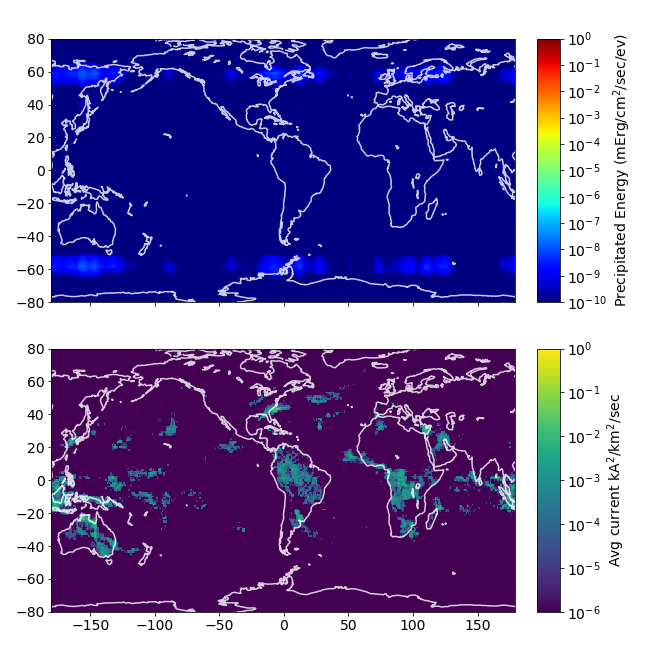

-inf -7.81959302211
-100.0 -1.37944444148


In [212]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------







# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

file_duration = datetime.timedelta(hours=24).total_seconds()


print np.shape(d['flux'])

fig, ax = plt.subplots(2,2, sharex='col', gridspec_kw={'width_ratios': [1, 0.05]})

band_index = 3

clims = [-10,0]
pdat = np.log10(d['flux'][:,:,band_index].T) - np.log10(file_duration)
print np.min(pdat), np.max(pdat)
p0 = ax[0,0].pcolormesh(gridlons, gridlats, pdat, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))
ax[0,0].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[0,0].set_xlim([-180,179])
ax[0,0].set_ylim([-80, 80])

cb = plt.colorbar(p0, cax=ax[0,1])
cb.set_label('Precipitated Energy (mErg/cm$^2$/sec/ev)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)

cmt = d['cur_map']

cmt = cmt # Arrives from precip_seasonal_parallel as A^2/sec
# cmt  = cmt / 8
# cmt *= sec_in_year
cmt = cmt/(1000.*1000.)
cell_areas_1deg = np.abs((R_E*D2R)*(R_E*D2R)*np.cos((np.arange(-90,90) + dlat)*D2R))


cmt = cmt / cell_areas_1deg[:,np.newaxis]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100
print np.min(cmt), np.max(cmt)


clims2 = [-6, 0]


p1 = ax[1,0].pcolormesh(np.arange(-180,180), np.arange(-90,90),cmt,
                        vmin=clims2[0], vmax=clims2[1], cmap=plt.get_cmap('viridis'))
ax[1,0].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[1,0].set_ylim([-80,80])
cb2 = plt.colorbar(p1, cax=ax[1,1])
cb2.set_label('Avg current kA$^2$/km$^2$/sec')
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)

fig.tight_layout()
# ax[0,].set_ylim([-80,80])


In [107]:
dlat = 1
dlon = 1
stencil_lats = np.hstack([np.arange(-80, -19,dlat),(np.arange(20,80 + dlat,dlat))])
stencil_lons = np.linspace(-14, 14, 14*2/dlon + 1)
print stencil_lats

[-80.  -79.5 -79.  -78.5 -78.  -77.5 -77.  -76.5 -76.  -75.5 -75.  -74.5
 -74.  -73.5 -73.  -72.5 -72.  -71.5 -71.  -70.5 -70.  -69.5 -69.  -68.5
 -68.  -67.5 -67.  -66.5 -66.  -65.5 -65.  -64.5 -64.  -63.5 -63.  -62.5
 -62.  -61.5 -61.  -60.5 -60.  -59.5 -59.  -58.5 -58.  -57.5 -57.  -56.5
 -56.  -55.5 -55.  -54.5 -54.  -53.5 -53.  -52.5 -52.  -51.5 -51.  -50.5
 -50.  -49.5 -49.  -48.5 -48.  -47.5 -47.  -46.5 -46.  -45.5 -45.  -44.5
 -44.  -43.5 -43.  -42.5 -42.  -41.5 -41.  -40.5 -40.  -39.5 -39.  -38.5
 -38.  -37.5 -37.  -36.5 -36.  -35.5 -35.  -34.5 -34.  -33.5 -33.  -32.5
 -32.  -31.5 -31.  -30.5 -30.  -29.5 -29.  -28.5 -28.  -27.5 -27.  -26.5
 -26.  -25.5 -25.  -24.5 -24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5
 -20.  -19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.   24.5
  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.   30.5
  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.   36.5
  37.   37.5  38.   38.5  39.   39.5  40.   40.5  4

In [120]:
print len(stencil_lats), len(stencil_lons)

141 29


In [148]:
cur_lon = 15

lonleft  = int((cur_lon + stencil_lons[0])/dlon + len(gridlons)/2)
lonright = int((cur_lon + stencil_lons[-1])/dlon + len(gridlons)/2) + 1

print lonleft, lonright
print gridlons[lonleft], gridlons[lonright]
print lonright - lonleft

362 419
1.0 29.5
57


<IPython.core.display.Javascript object>


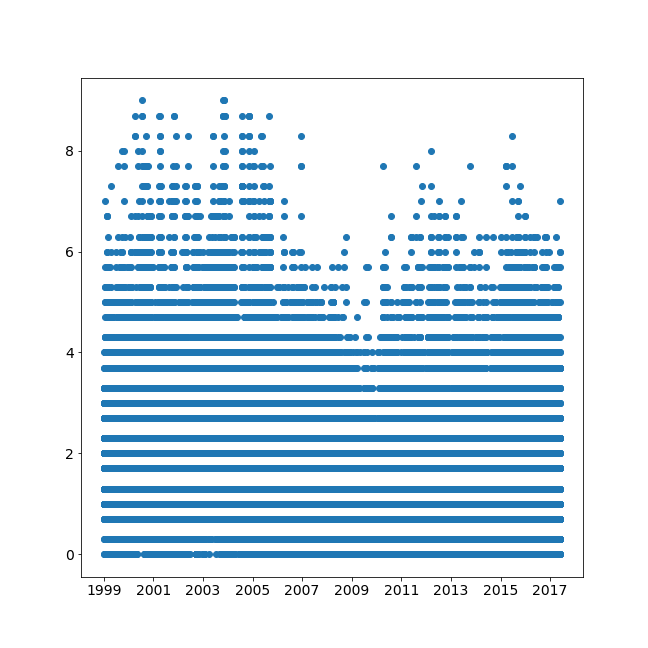

In [223]:
from methods.index_helpers import load_Kp

ktimes, kvals = load_Kp()
plt.figure()
plt.plot(ktimes, kvals,'o')